## Equação do Calor 1D

Este notebook resolve a equação do calor (ou difusão) 1D transiente:
$$ \frac{\partial U}{\partial t} = \alpha \frac{\partial^2 U}{\partial x^2} $$

Utilizamos o **Método das Linhas (MOL)**, que consiste em discretizar a dimensão espacial (x) para transformar a Equação Diferencial Parcial (EDP) num sistema de Equações Diferenciais Ordinárias (EDOs) no tempo.

A discretização espacial é feita com o **Método das Diferenças Finitas**.

### Condições do Problema

- **Domínio:** $x \in [0, L]$
- **Condição Inicial (CI):** $U(x, 0) = \cos(\frac{\pi x}{L})$
- **Condições de Contorno (CC):** Tipo Neumann, representando extremidades isoladas (fluxo de calor nulo).
  $$ \frac{\partial U}{\partial x}(0, t) = 0 \quad \text{e} \quad \frac{\partial U}{\partial x}(L, t) = 0 $$

### Discretização Espacial por Diferenças Finitas

A segunda derivada espacial é aproximada pela fórmula de diferenças finitas centrada de segunda ordem:
$$ \frac{\partial^2 U}{\partial x^2} \bigg|_{x=x_i} \approx \frac{U_{i+1} - 2U_i + U_{i-1}}{(\Delta x)^2} $$

Substituindo na EDP, obtemos um sistema de EDOs para cada ponto $i$ da malha:
$$ \frac{dU_i}{dt} = \alpha \frac{U_{i+1} - 2U_i + U_{i-1}}{(\Delta x)^2} $$

### Tratamento das Condições de Contorno de Neumann

Para os pontos nos extremos ($i=0$ e $i=N_x-1$), a fórmula padrão precisa de pontos "fantasmas" ($U_{-1}$ e $U_{N_x}$). Podemos determinar os valores desses pontos usando a discretização da própria condição de contorno.

**No contorno esquerdo (x=0, i=0):**
A condição é $\frac{\partial U}{\partial x} = 0$. Usando uma diferença finita centrada:
$$ \frac{U_1 - U_{-1}}{2\Delta x} = 0 \implies U_{-1} = U_1 $$
Substituindo $U_{-1}$ na EDO para $i=0$:
$$ \frac{dU_0}{dt} = \alpha \frac{U_1 - 2U_0 + U_1}{(\Delta x)^2} = \alpha \frac{2(U_1 - U_0)}{(\Delta x)^2} $$

**No contorno direito (x=L, i=N_x-1):**
A condição é $\frac{\partial U}{\partial x} = 0$. Usando uma diferença finita centrada:
$$ \frac{U_{N_x} - U_{N_x-2}}{2\Delta x} = 0 \implies U_{N_x} = U_{N_x-2} $$
Substituindo $U_{N_x}$ na EDO para $i=N_x-1$:
$$ \frac{dU_{N_x-1}}{dt} = \alpha \frac{U_{N_x} - 2U_{N_x-1} + U_{N_x-2}}{(\Delta x)^2} = \alpha \frac{2(U_{N_x-2} - U_{N_x-1})}{(\Delta x)^2} $$

In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

### Definição dos Parâmetros do Problema

In [2]:
# Parâmetros Físicos
L = 1.0  # Comprimento da barra
alpha = 0.5  # Difusividade térmica

# Parâmetros da Simulação
t_final = 1.0  # Tempo final da simulação
Nx = 101  # Número de pontos no espaço (ímpar para ter um ponto central)
Nt = 101  # Número de pontos no tempo para a saída

### Discretização e Condição Inicial

In [3]:
# Discretização espacial
x = np.linspace(0, L, Nx)
dx = x[1] - x[0]

# Condição Inicial U(x, 0)
U0 = np.cos(np.pi * x / L)

# Vetor de tempo para a solução
t_span = [0, t_final]
t_eval = np.linspace(t_span[0], t_span[1], Nt)

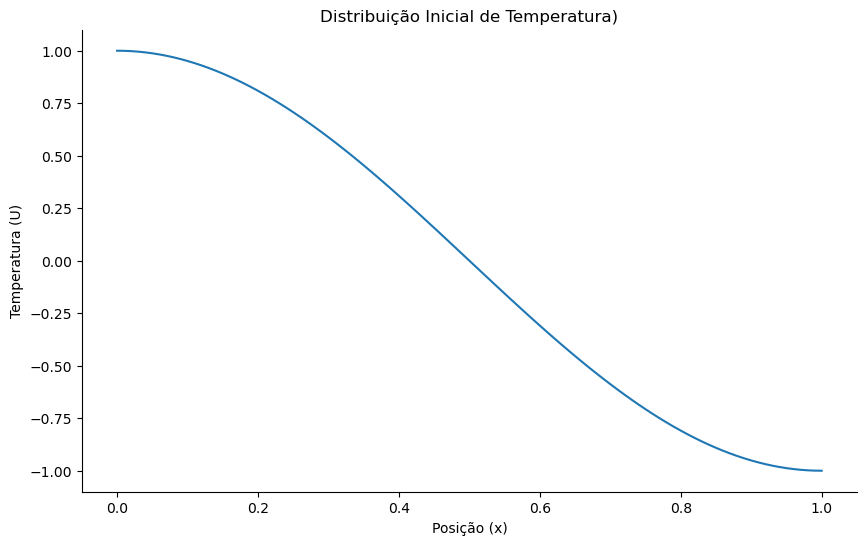

In [4]:
# Condição Inicial

plt.figure(figsize=(10, 6))

plt.plot(x, U0)

ax = plt.gca()
ax.set_title("Distribuição Inicial de Temperatura)", fontsize=12)
ax.set_xlabel("Posição (x)", fontsize=10)
ax.set_ylabel("Temperatura (U)", fontsize=10)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

### Definição da Função do Sistema de EDOs

In [5]:
def heat_eq_odes_neumann(t, U, alpha, dx, Nx):
    """
    Define o sistema de EDOs para a equação do calor com CC de Neumann.
    U é o vetor de temperaturas nos pontos da malha.
    """

    # Inicializa o vetor de derivadas (dU/dt)
    dUdt = np.zeros_like(U)

    # Pontos Internos (i = 1 a Nx-2)
    # Usa a fórmula de diferenças finitas centrada padrão
    dUdt[1:-1] = alpha * (U[2:] - 2 * U[1:-1] + U[:-2]) / dx**2

    # Condições de Contorno de Neumann
    # Contorno Esquerdo (i = 0)
    dUdt[0] = alpha * 2 * (U[1] - U[0]) / dx**2

    # Contorno Direito (i = Nx-1)
    dUdt[-1] = alpha * 2 * (U[-2] - U[-1]) / dx**2

    return dUdt

### Resolução Numérica do Sistema de EDOs

In [6]:
# Usamos 'solve_ivp' do SciPy para integrar o sistema de EDOs
sol = solve_ivp(
    fun=heat_eq_odes_neumann,
    t_span=t_span,
    y0=U0,
    args=(alpha, dx, Nx),
    t_eval=t_eval,
    dense_output=True,
)

# Extrai a solução. A saída de solve_ivp tem shape (Nx, Nt),
# então transpomos para (Nt, Nx) para facilitar a plotagem.
U_sol = sol.y.T

### Visualização dos Resultados

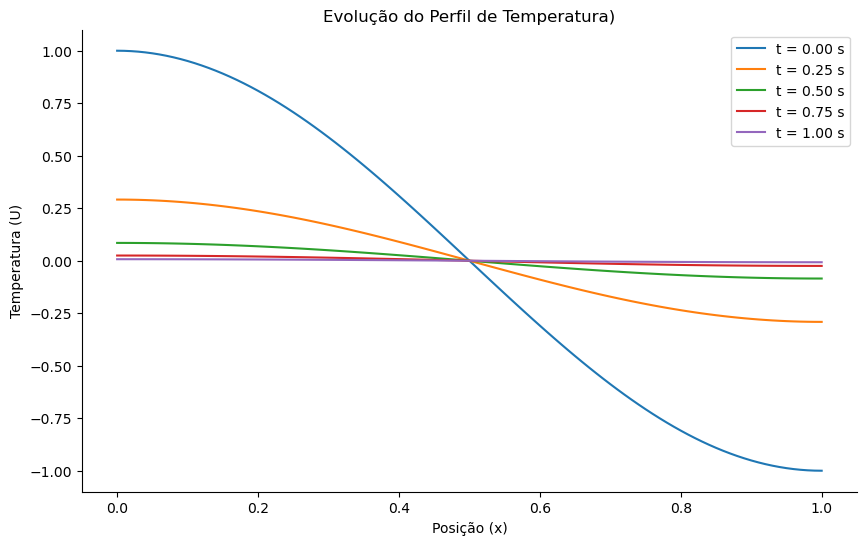

In [7]:
# Perfis de Temperatura ao Longo do Tempo

fig, ax = plt.subplots(figsize=(10, 6))

idx_time = [0, Nt // 4, Nt // 2, 3 * Nt // 4, Nt - 1]  # Pega 5 instantes de tempo
for i, t_idx in enumerate(idx_time):
    ax.plot(x, U_sol[t_idx, :], label=f"t = {t_eval[t_idx]:.2f} s")

ax.set_title("Evolução do Perfil de Temperatura)", fontsize=12)
ax.set_xlabel("Posição (x)", fontsize=10)
ax.set_ylabel("Temperatura (U)", fontsize=10)
ax.legend()

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

A condição inicial $\cos(\pi x/L)$ tem gradientes nulos em $x=0$ e $x=L$, satisfazendo naturalmente as condições de contorno de Neumann. O resultado esperado é que a temperatura se dissipe até atingir um valor médio constante em toda a barra, já que não há fluxo de calor para fora do sistema.

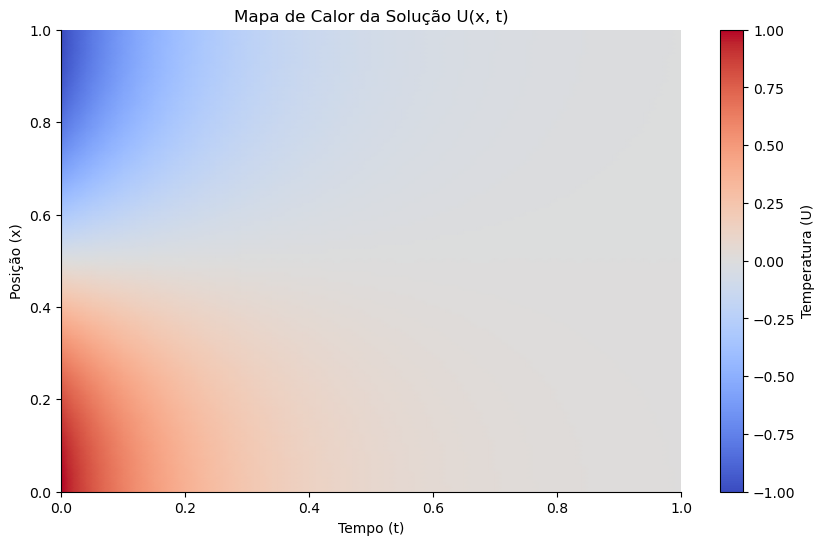

In [8]:
# Mapa de Calor U(x, t)

fig, ax = plt.subplots(figsize=(10, 6))

# Meshgrid para as coordenadas. Note que pcolormesh usa as coordenadas dos cantos.
T_grid, X_grid = np.meshgrid(t_eval, x)

# A matriz de cores (U_sol.T) deve ter dimensões (Nx, Nt)
# Usamos shading='gouraud' para interpolação suave de cores.
im = ax.pcolormesh(T_grid, X_grid, U_sol.T, cmap="coolwarm", shading="gouraud")

# Adiciona a barra de cores
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Temperatura (U)", fontsize=10)

ax.set_title("Mapa de Calor da Solução U(x, t)", fontsize=12)
ax.set_xlabel("Tempo (t)", fontsize=10)
ax.set_ylabel("Posição (x)", fontsize=10)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

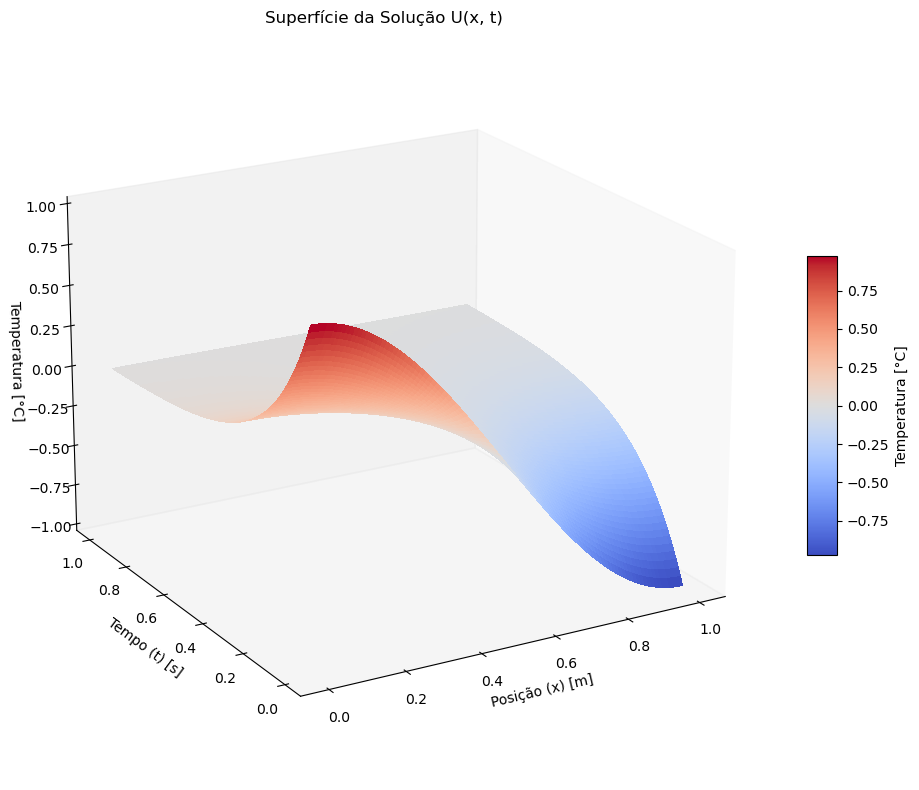

In [9]:
# Superfície U(x, t)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

T, X = np.meshgrid(t_eval, x)

# A solução precisa ser transposta de volta para (Nx, Nt) para o meshgrid
surf = ax.plot_surface(
    X, T, U_sol.T, cmap="coolwarm", rstride=1, cstride=1, antialiased=False
)

ax.set_title("Superfície da Solução U(x, t)", fontsize=12)
ax.set_xlabel("Posição (x) [m]", fontsize=10)
ax.set_ylabel("Tempo (t) [s]", fontsize=10)
ax.set_zlabel("Temperatura [°C]", fontsize=10)

ax.grid(False)

# Adiciona uma Barra de Cores
# A barra de cores mapeia as cores da superfície para os valores de temperatura
fig.colorbar(surf, shrink=0.4, aspect=10, label="Temperatura [°C]")

# Ajusta o Ângulo de Visualização
# (azimute, elevação) para uma melhor perspectiva
ax.view_init(elev=20, azim=-120)

plt.tight_layout()

### Exportando os Resultados

In [10]:
# Achatar (flatten) todas as matrizes para vetores 1D
x_flat = X.flatten()
t_flat = T.flatten()
k_flat = U_sol.flatten()

# Empilhar os vetores como colunas
data_np = np.column_stack([x_flat, t_flat, k_flat])

print("Shape do resultado:", data_np.shape)

data = pd.DataFrame(data_np, columns=["position", "time", "temperature"])
print("Resultado:")
display(data)

data.to_csv("../data/heat_equation neumann.csv")

Shape do resultado: (10201, 3)
Resultado:


,position,time,temperature
0,0.0,0.00,1.000000
1,0.0,0.01,0.999507
2,0.0,0.02,0.998027
3,0.0,0.03,0.995562
4,0.0,0.04,0.992115
...,...,...,...
10196,1.0,0.96,-0.007139
10197,1.0,0.97,-0.007162
10198,1.0,0.98,-0.007182
10199,1.0,0.99,-0.007190
